# TimeSeriesMatrix Tutorial

`TimeSeriesMatrix` is a 3-dimensional array container that extends `SeriesMatrix` for TimeSeries (shape: Nrow × Ncol × Nsample).

- TimeSeries-compatible aliases such as `dt / t0 / times`
- Element access returns `TimeSeries` (`tsm[i, j]`)
- Time-domain processing (detrend/bandpass/resample ...) applied element-wise
- Spectral analysis such as FFT/PSD/ASD and coherence (returns `FrequencySeriesMatrix`)
- Display methods (`plot`, `step`, `repr`, `_repr_html_`) work out of the box

In this notebook, we do not define additional utility functions but directly call class methods to verify their behavior.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix

## Prepare Representative Data
- Create a 2×2 `TimeSeriesMatrix` and check `dt/t0/times` and metadata (unit/name/channel).

<SeriesMatrix shape=(2, 2, 1024) rows=('r0', 'r1') cols=('c0', 'c1')>

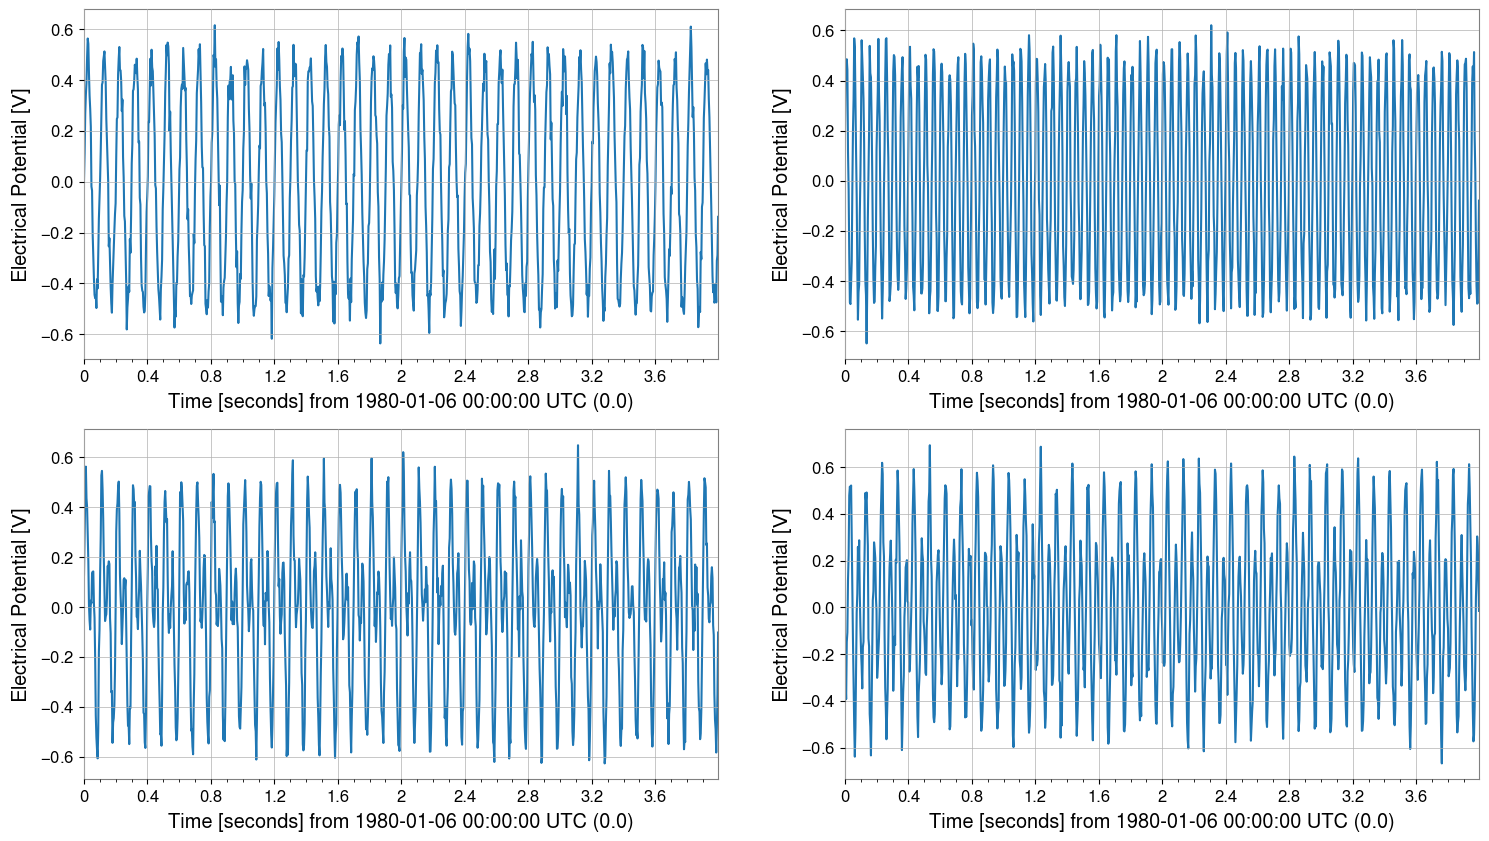

In [2]:
rng = np.random.default_rng(0)

# Sample configuration
n = 1024
dt = (1 / 256) * u.s
t0 = 0 * u.s

t = (np.arange(n) * dt).to_value(u.s)

tone10 = np.sin(2 * np.pi * 10 * t)
tone20 = np.sin(2 * np.pi * 20 * t + 0.3)

data = np.empty((2, 2, n), dtype=float)
data[0, 0] = 0.5 * tone10 + 0.05 * rng.normal(size=n)
data[0, 1] = 0.5 * tone20 + 0.05 * rng.normal(size=n)
data[1, 0] = 0.3 * tone10 + 0.3 * tone20 + 0.05 * rng.normal(size=n)
data[1, 1] = 0.2 * tone10 - 0.4 * tone20 + 0.05 * rng.normal(size=n)

units = np.full((2, 2), u.V)
names = [["ch00", "ch01"], ["ch10", "ch11"]]
channels = [["X:A", "X:B"], ["Y:A", "Y:B"]]

tsm = TimeSeriesMatrix(
    data,
    dt=dt,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="demo",
)

display(tsm)
tsm.plot();

## Various Input Patterns (Constructor Examples)
In addition to `dt/t0`, we verify `sample_rate` or `times`, 2D lists of `TimeSeries`, `Quantity` input, etc.

In [3]:
print("=== TimeSeriesMatrix Constructor Examples ===")
times = tsm.times

# Case 1: Specify sample_rate (instead of dt)
tsm_sr = TimeSeriesMatrix(
    data,
    sample_rate=256 * u.Hz,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
)
print("case1 sample_rate", "dt", tsm_sr.dt, "sample_rate", tsm_sr.sample_rate)

# Case 2: Specify times (also supports irregular sampling)
tsm_times = TimeSeriesMatrix(data, times=times, units=units, names=names)
print("case2 times", "dt", tsm_times.dt, "t0", tsm_times.t0, "N", tsm_times.N_samples)

# Case 3: Construct from a 2D list of TimeSeries
ts00 = TimeSeries(data[0, 0], times=times, unit=u.V, name="ch00", channel="X:A")
ts01 = TimeSeries(data[0, 1], times=times, unit=u.V, name="ch01", channel="X:B")
ts10 = TimeSeries(data[1, 0], times=times, unit=u.V, name="ch10", channel="Y:A")
ts11 = TimeSeries(data[1, 1], times=times, unit=u.V, name="ch11", channel="Y:B")
tsm_from_ts = TimeSeriesMatrix([[ts00, ts01], [ts10, ts11]])
print("case3 from TimeSeries", tsm_from_ts.shape, "dt", tsm_from_ts.dt)

# Case 4: Quantity input (units are automatically set)
tsm_q = TimeSeriesMatrix((data * u.mV), dt=dt, t0=t0)
print("case4 Quantity meta unit", tsm_q.meta[0, 0].unit)

# Exception: dt and sample_rate / t0 and epoch cannot be specified simultaneously
for kwargs in [
    dict(dt=dt, sample_rate=256 * u.Hz, t0=t0),
    dict(dt=dt, t0=t0, epoch=t0),
]:
    try:
        _ = TimeSeriesMatrix(data, **kwargs)
    except Exception as e:
        print("error", kwargs, "->", type(e).__name__, e)

=== TimeSeriesMatrix Constructor Examples ===
case1 sample_rate dt 0.00390625 s sample_rate 256.0 Hz
case2 times dt 0.00390625 s t0 0.0 s N 1024
case3 from TimeSeries (2, 2, 1024) dt 0.00390625 s
case4 Quantity meta unit mV
error {'dt': <Quantity 0.00390625 s>, 'sample_rate': <Quantity 256. Hz>, 't0': <Quantity 0. s>} -> ValueError give only one of sample_rate or dt
error {'dt': <Quantity 0.00390625 s>, 't0': <Quantity 0. s>, 'epoch': <Quantity 0. s>} -> ValueError give only one of epoch or t0


## Indexing and Slicing
- `tsm[i, j]` returns a `TimeSeries`
- Slicing returns a `TimeSeriesMatrix`
- Can also access via row/col labels

[0,0] type <class 'gwexpy.timeseries.timeseries.TimeSeries'> dt 0.00390625 s t0 0.0 s unit V
[0,0] name ch00 channel X:A
[r0,c1] name ch01 channel X:B
tsm[:,0] -> <class 'gwexpy.timeseries.matrix.TimeSeriesMatrix'> (2, 1, 1024)


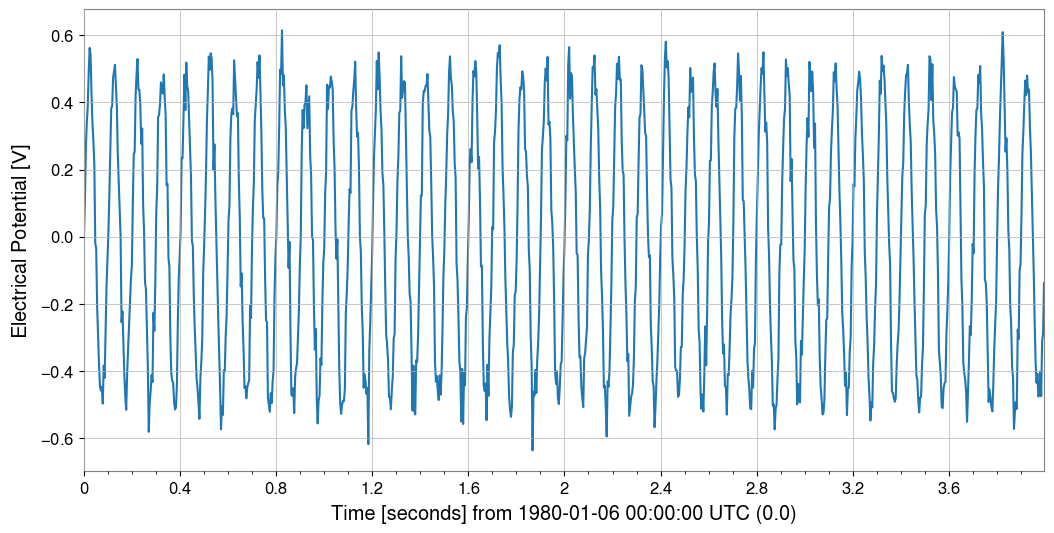

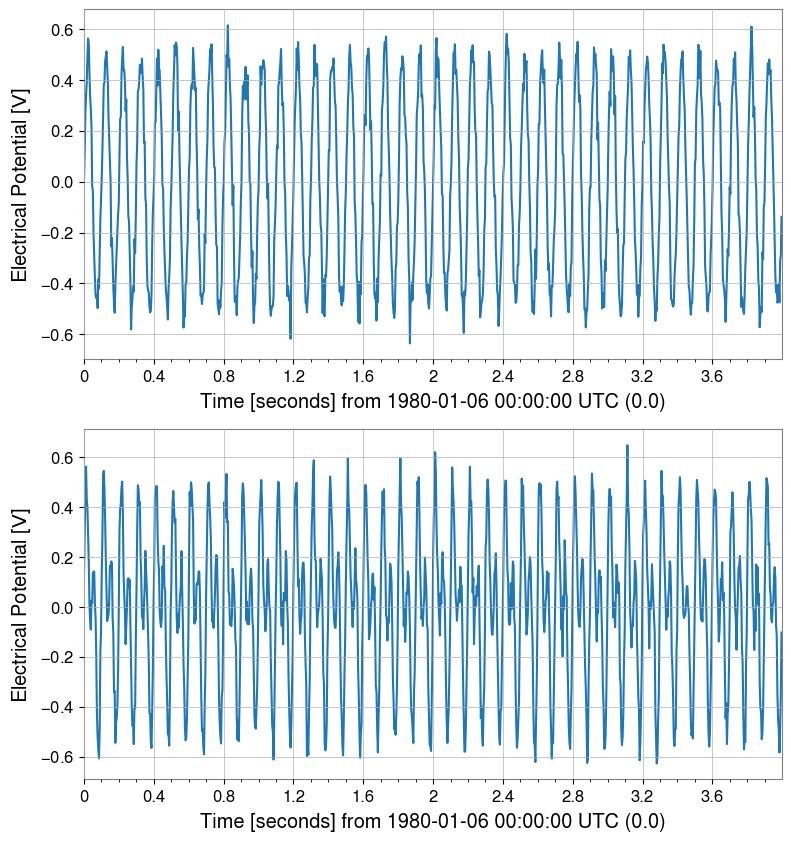

In [4]:
s00 = tsm[0, 0]
print("[0,0]", "type", type(s00), "dt", s00.dt, "t0", s00.t0, "unit", s00.unit)
print("[0,0]", "name", s00.name, "channel", s00.channel)
s00.plot(xscale="seconds")

s01 = tsm["r0", "c1"]
print("[r0,c1]", "name", s01.name, "channel", s01.channel)

sub = tsm[:, 0]
print("tsm[:,0] ->", type(sub), sub.shape)
sub.plot(subplots=True, xscale="seconds");

## Sample Axis Editing
- `diff` / `pad` return `TimeSeriesMatrix`
- `crop` currently returns `SeriesMatrix`, so use `view(TimeSeriesMatrix)` to restore (contents are the same)

cropped <class 'gwexpy.timeseries.matrix.TimeSeriesMatrix'> (2, 2, 256) span (<Quantity 1. s>, <Quantity 2. s>)


diffed (2, 2, 1023) dt 0.00390625 s


padded (2, 2, 1124) t0 -0.1953125 s


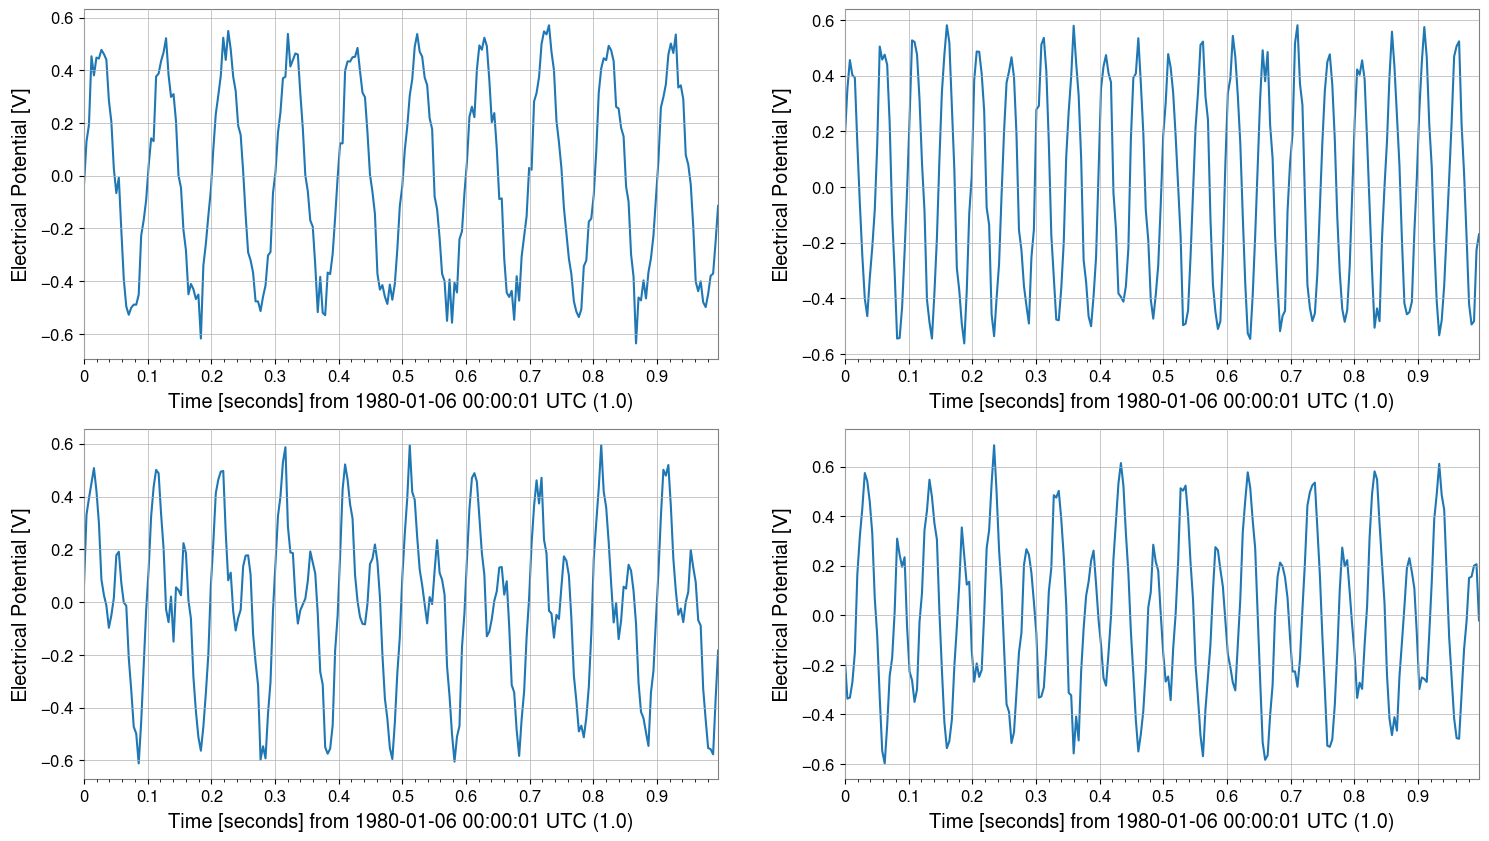

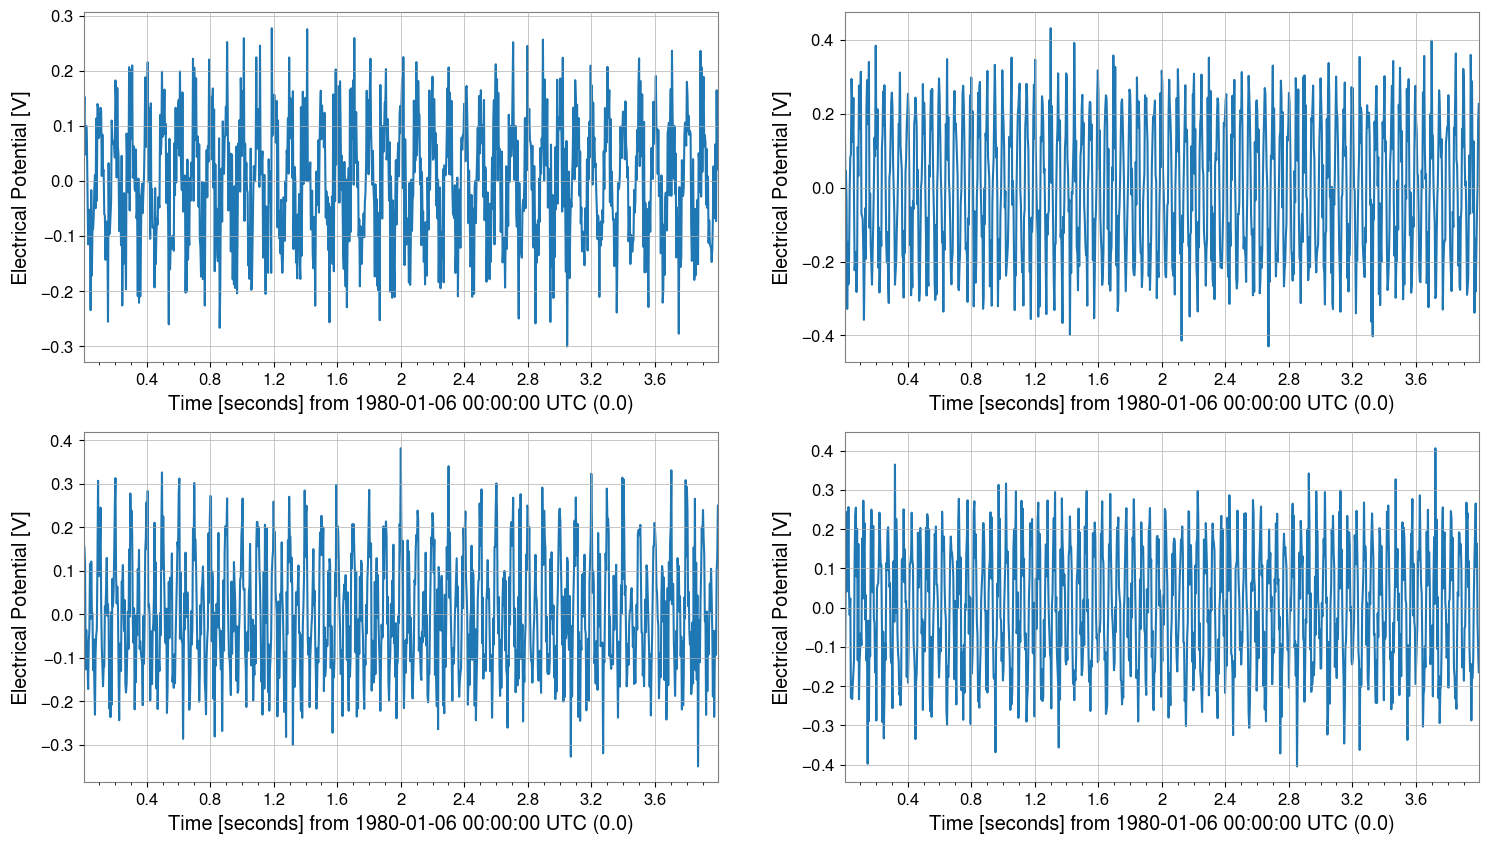

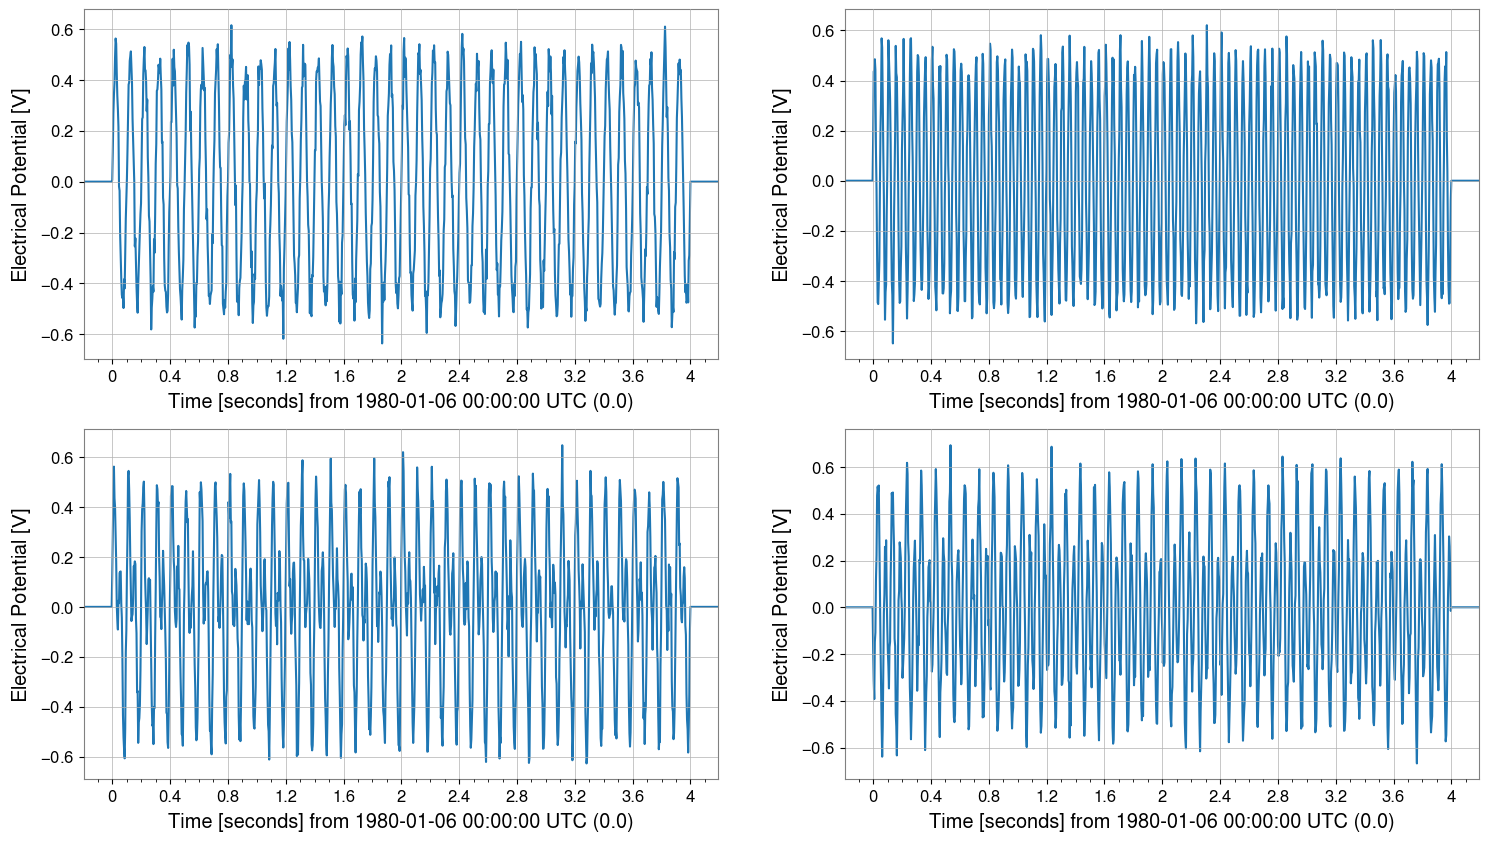

In [5]:
cropped = tsm.crop(start=1 * u.s, end=2 * u.s).view(TimeSeriesMatrix)
print("cropped", type(cropped), cropped.shape, "span", cropped.span)
cropped.plot(subplots=True, xscale="seconds")

diffed = tsm.diff(n=1)
print("diffed", diffed.shape, "dt", diffed.dt)
diffed.plot(subplots=True, xscale="seconds")

padded = tsm.pad(50)
print("padded", padded.shape, "t0", padded.t0)
padded.plot(subplots=True, xscale="seconds");

## Time-Domain Processing (Element-wise Application of TimeSeries Methods)
`TimeSeries` methods (`detrend`, `bandpass`, `resample`, etc.) are applied element-wise to the matrix.

original (2, 2, 1024) sample_rate 256.0 Hz
bandpass (2, 2, 1024) sample_rate 256.0 Hz
resample (2, 2, 512) sample_rate 128.0 Hz


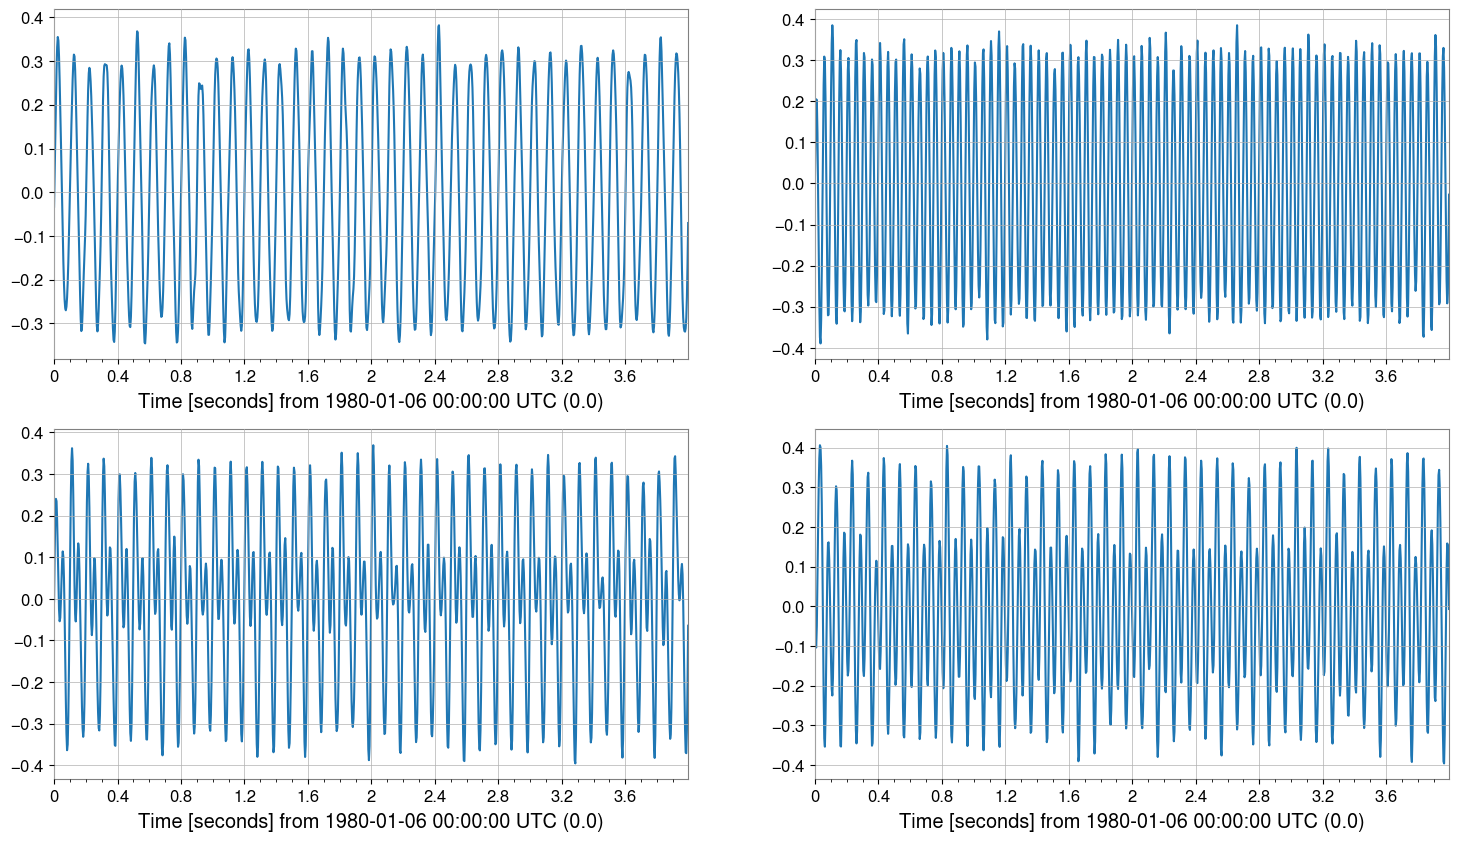

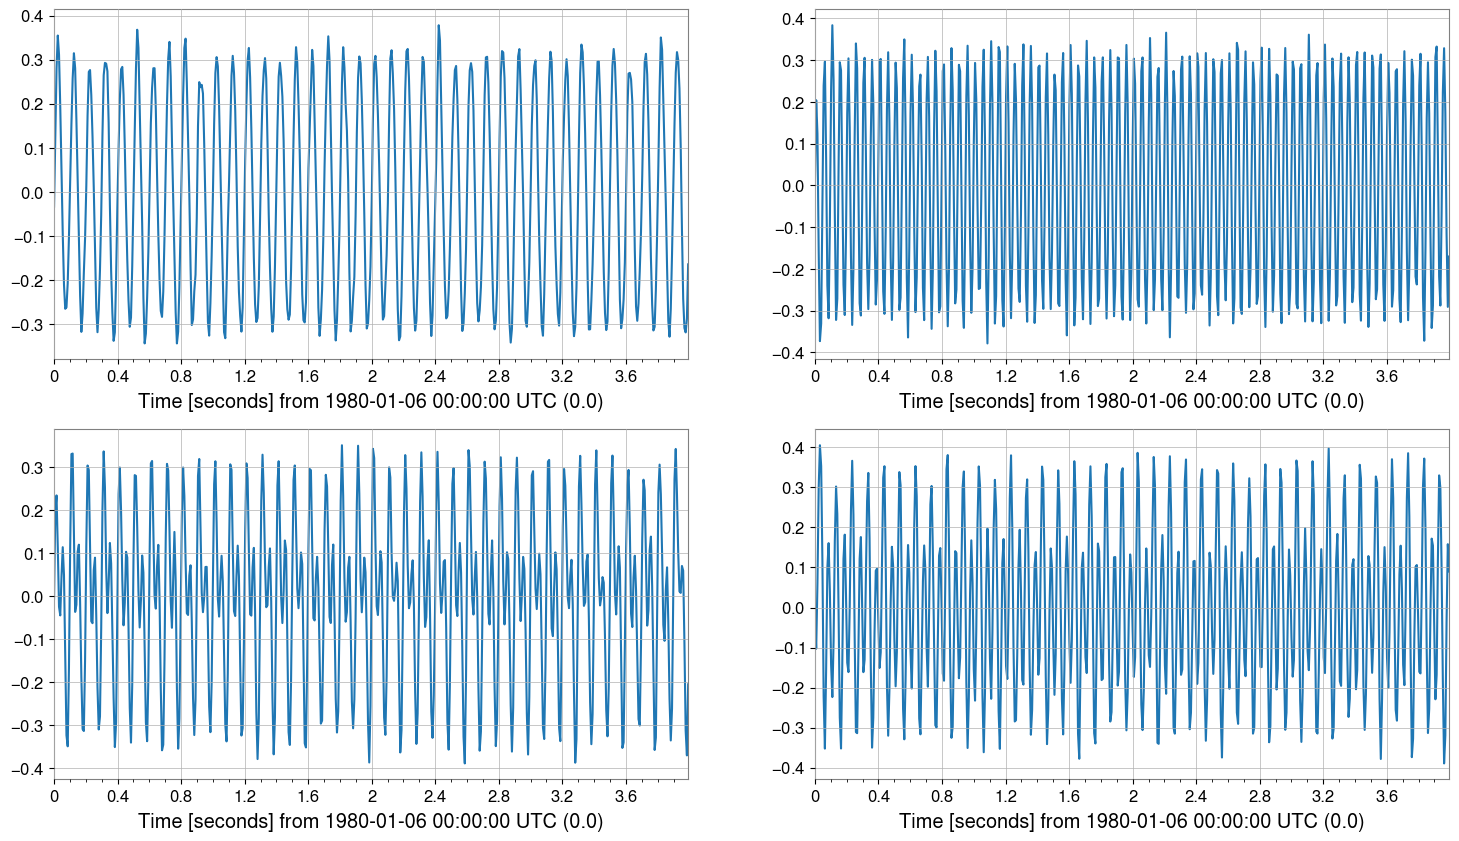

In [6]:
detr = tsm.detrend("constant")
bp = detr.bandpass(5, 40)
rs = bp.resample(128)

print("original", tsm.shape, "sample_rate", tsm.sample_rate)
print("bandpass", bp.shape, "sample_rate", bp.sample_rate)
print("resample", rs.shape, "sample_rate", rs.sample_rate)

bp.plot(subplots=True, xscale="seconds")
rs.plot(subplots=True, xscale="seconds");

## Missing Value Imputation
Impute missing values (NaN) in the matrix. Applied to each channel separately.

In [7]:
# Create data with missing values (for demo)
tsm_miss = tsm.copy()
# Set some values to NaN in the first channel (note how to access: tsm[0,0] is a time series)
tsm_miss[0, 0].value[50:60] = np.nan

print("Before impute (Has NaN):", np.isnan(tsm_miss[0, 0].value).any())

# Impute (linear interpolation)
tsm_imp = tsm_miss.impute(method="interpolate")
print("After impute (Has NaN):", np.isnan(tsm_imp[0, 0].value).any())

Before impute (Has NaN): False
After impute (Has NaN): False


## Preprocessing: Standardization and Whitening
Useful as preprocessing for multivariate analysis.

In [8]:
# Standardize: Scale to mean 0, variance 1
tsm_std = tsm.standardize(method="zscore")

# Whiten: Remove inter-channel correlation (covariance)
# Use PCA to decorrelate
tsm_white, w_model = tsm_std.whiten_channels(return_model=True)

print("Standardized shape:", tsm_std.shape)
print("Whitened shape:", tsm_white.shape)

Standardized shape: (2, 2, 1024)
Whitened shape: (4, 1, 1024)


## Decomposition (PCA / ICA)
Efficient dimensionality reduction or source separation.

PCA Scores shape: (2, 1, 1024)
Explained variance ratio: [0.57128681 0.41742564]


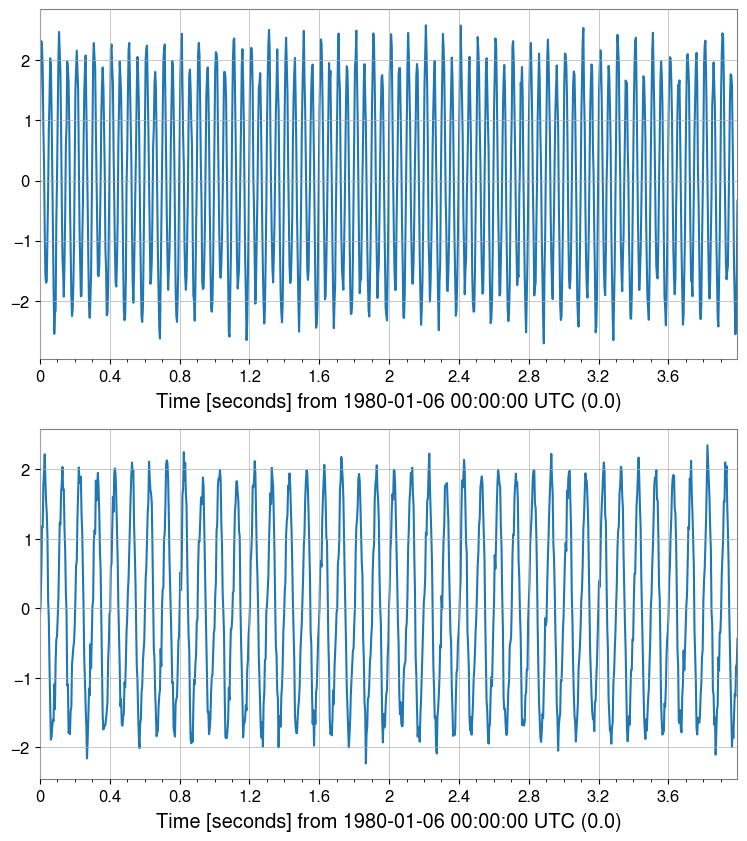

ICA Sources shape: (2, 1, 1024)


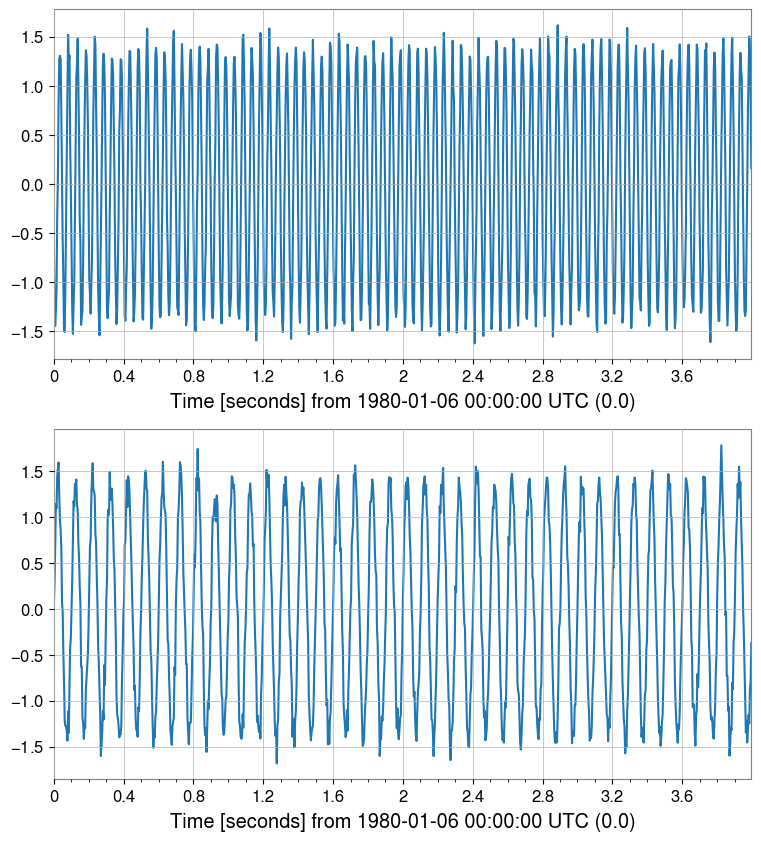

In [9]:
# Principal Component Analysis (PCA)
# Dimensionality reduction (e.g., 3 channels -> 2 principal components)
n_comp = min(2, tsm.shape[0])
pca_scores, pca_res = tsm_std.pca(n_components=n_comp, return_model=True)

print("PCA Scores shape:", pca_scores.shape)
print("Explained variance ratio:", pca_res.explained_variance_ratio)
pca_scores.plot()
plt.show()
plt.close()

# Independent Component Analysis (ICA)
# Blind Source Separation
ica_sources = tsm_std.ica(n_components=n_comp, random_state=42)
print("ICA Sources shape:", ica_sources.shape)
ica_sources.plot()
plt.show()
plt.close()

## Interoperability Introduction
Data can be passed to external libraries such as PyTorch.

In [10]:
try:
    # Convert to PyTorch Tensor
    import torch

    _ = torch
    tensor = tsm.to_torch()
    print("Converted to PyTorch:", tensor.shape)
except ImportError:
    print("PyTorch not installed")

Converted to PyTorch: torch.Size([2, 2, 1024])


## Spectral Analysis (FFT / PSD / ASD)
`fft/psd/asd` return `FrequencySeriesMatrix`.

fft <class 'gwexpy.frequencyseries.matrix.FrequencySeriesMatrix'> (2, 2, 513) df 0.25 Hz f0 0.0 Hz


psd (2, 2, 129) unit V2 / Hz
asd (2, 2, 129) unit V / Hz(1/2)


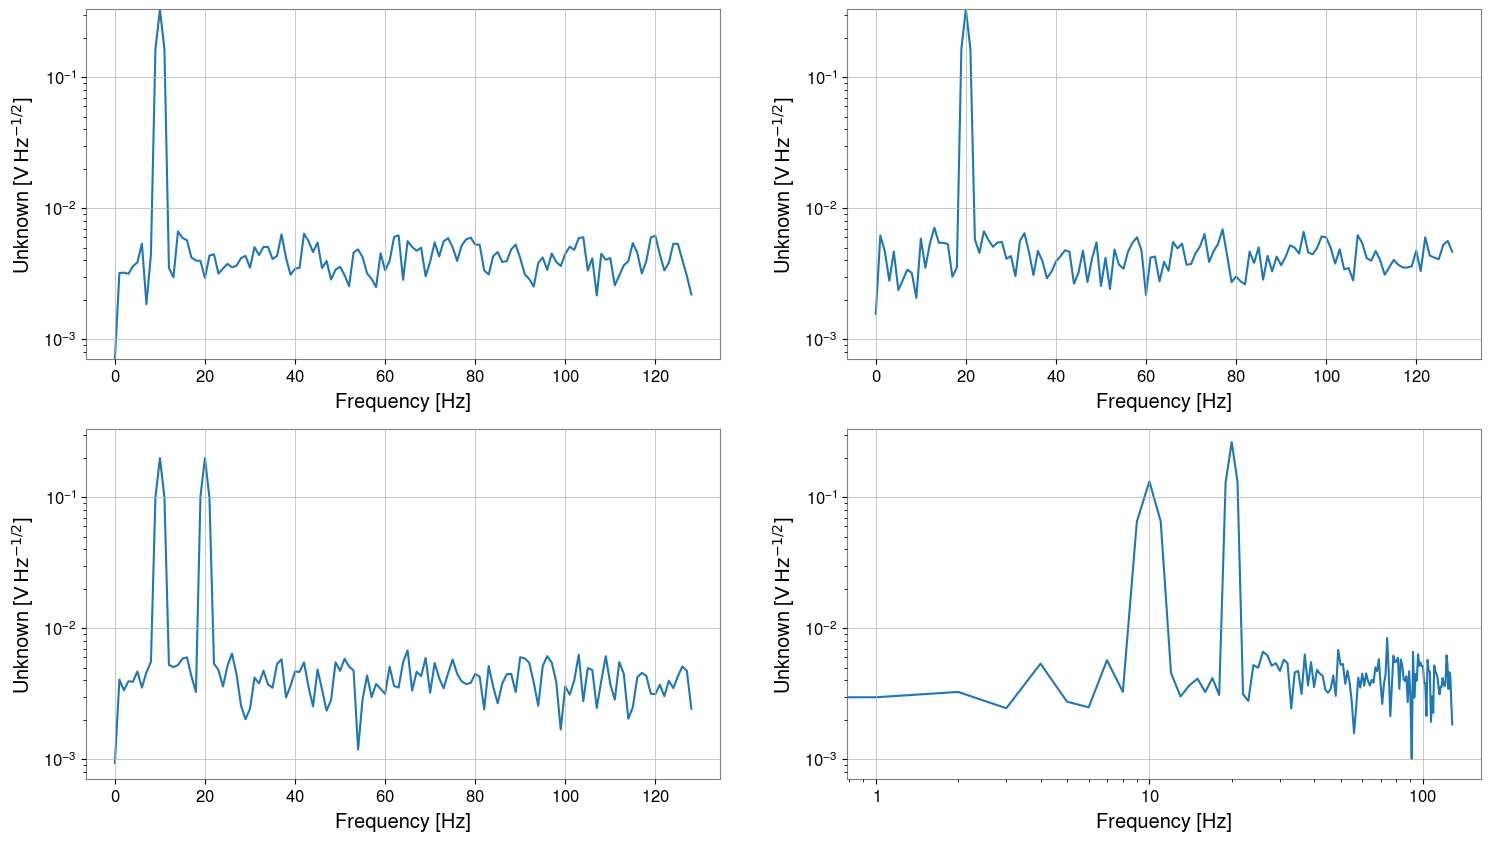

In [11]:
fft = tsm.fft()
print("fft", type(fft), fft.shape, "df", fft.df, "f0", fft.f0)

psd = tsm.psd(fftlength=1, overlap=0.5)
asd = tsm.asd(fftlength=1, overlap=0.5)
print("psd", psd.shape, "unit", psd[0, 0].unit)
print("asd", asd.shape, "unit", asd[0, 0].unit)

asd.plot(subplots=True)
plt.xscale("log")
plt.yscale("log")

## Bivariate Spectral Analysis (Coherence Example)
`TimeSeriesMatrix.coherence(other)` computes coherence element-wise and returns `FrequencySeriesMatrix`.

- Passing a `TimeSeries` as `other` compares "all elements vs. the same reference"
- Passing a `TimeSeriesMatrix` as `other` requires matching shape (Nrow, Ncol)

coherence <class 'gwexpy.frequencyseries.matrix.FrequencySeriesMatrix'> (2, 2, 129) unit coherence
shape mismatch -> IndexError index 1 is out of bounds for axis 1 with size 1


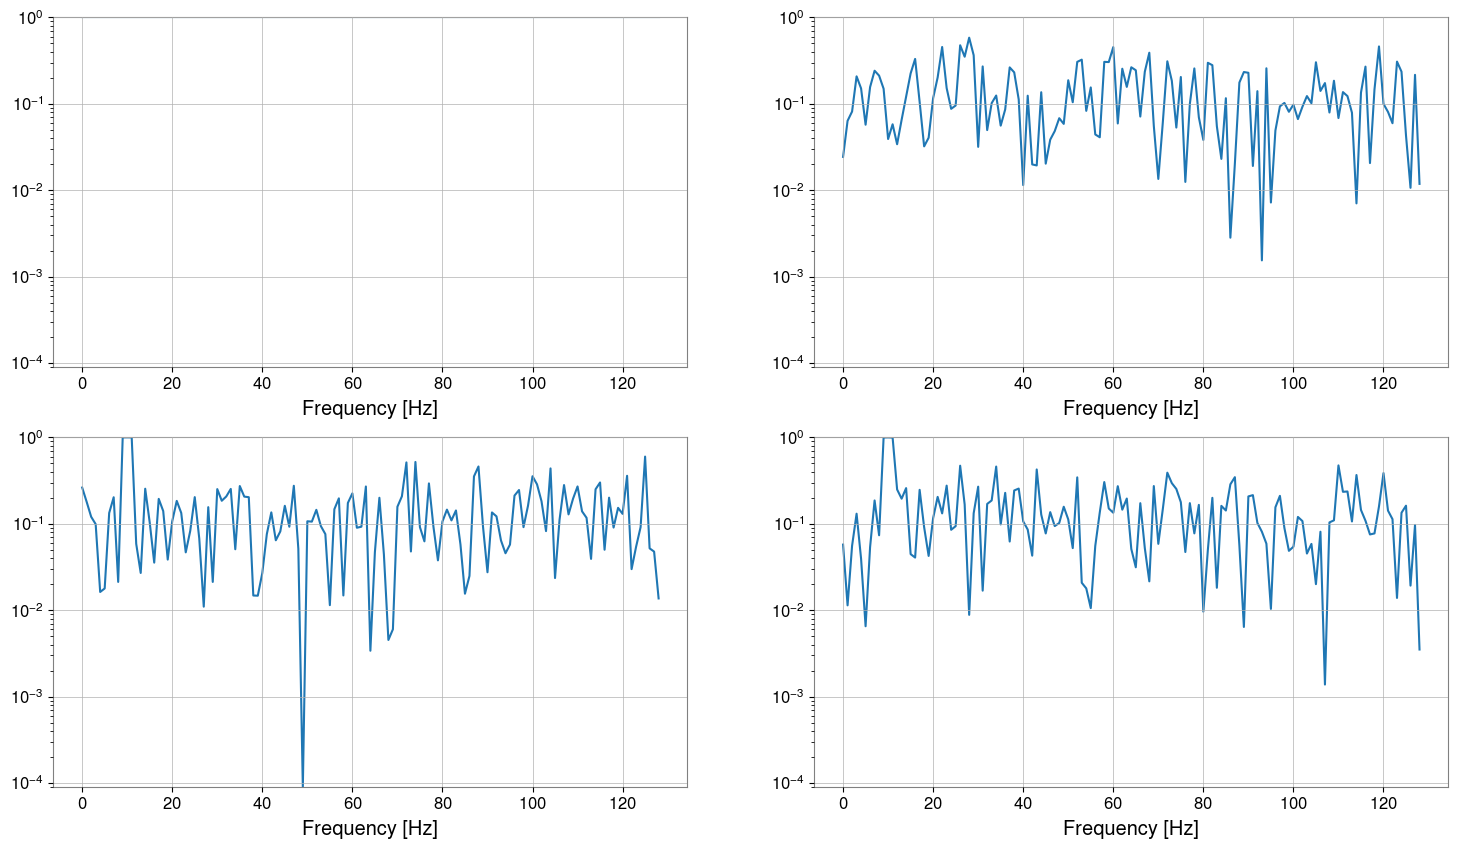

In [12]:
ref = tsm[0, 0]
coh = tsm.coherence(ref, fftlength=1, overlap=0.5)
print("coherence", type(coh), coh.shape, "unit", coh[0, 0].unit)
coh.plot(subplots=True)

try:
    _ = tsm.coherence(tsm[:, :1], fftlength=1)
except Exception as e:
    print("shape mismatch ->", type(e).__name__, e)

## Display Methods: repr / plot / step
- `repr`: Text display
- `_repr_html_`: In notebooks, `display(tsm)` shows a table format
- `plot` / `step`: Direct plotting with class methods

repr:
 SeriesMatrix(shape=(2, 2, 1024),  name='demo')
  epoch   : 0.0 s
  x0      : 0.0 s
  dx      : 0.00390625 s
  xunit   : s
  samples : 1024

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
  unit  name channel  row  col
0    V  ch00     X:A    0    0
1    V  ch01     X:B    0    1
2    V  ch10     Y:A    1    0
3    V  ch11     Y:B    1    1


<SeriesMatrix shape=(2, 2, 1024) rows=('r0', 'r1') cols=('c0', 'c1')>

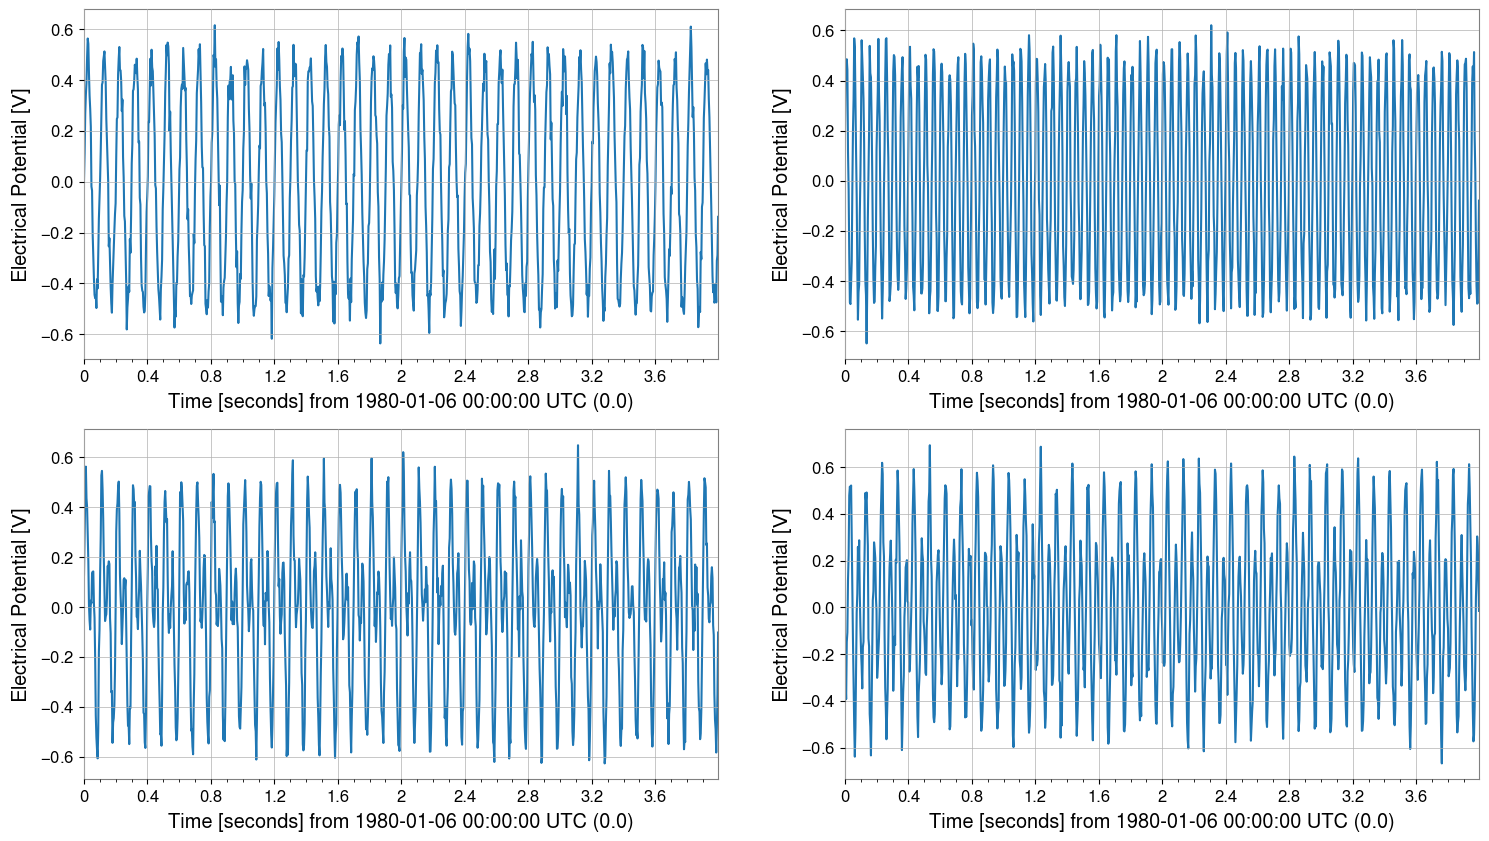

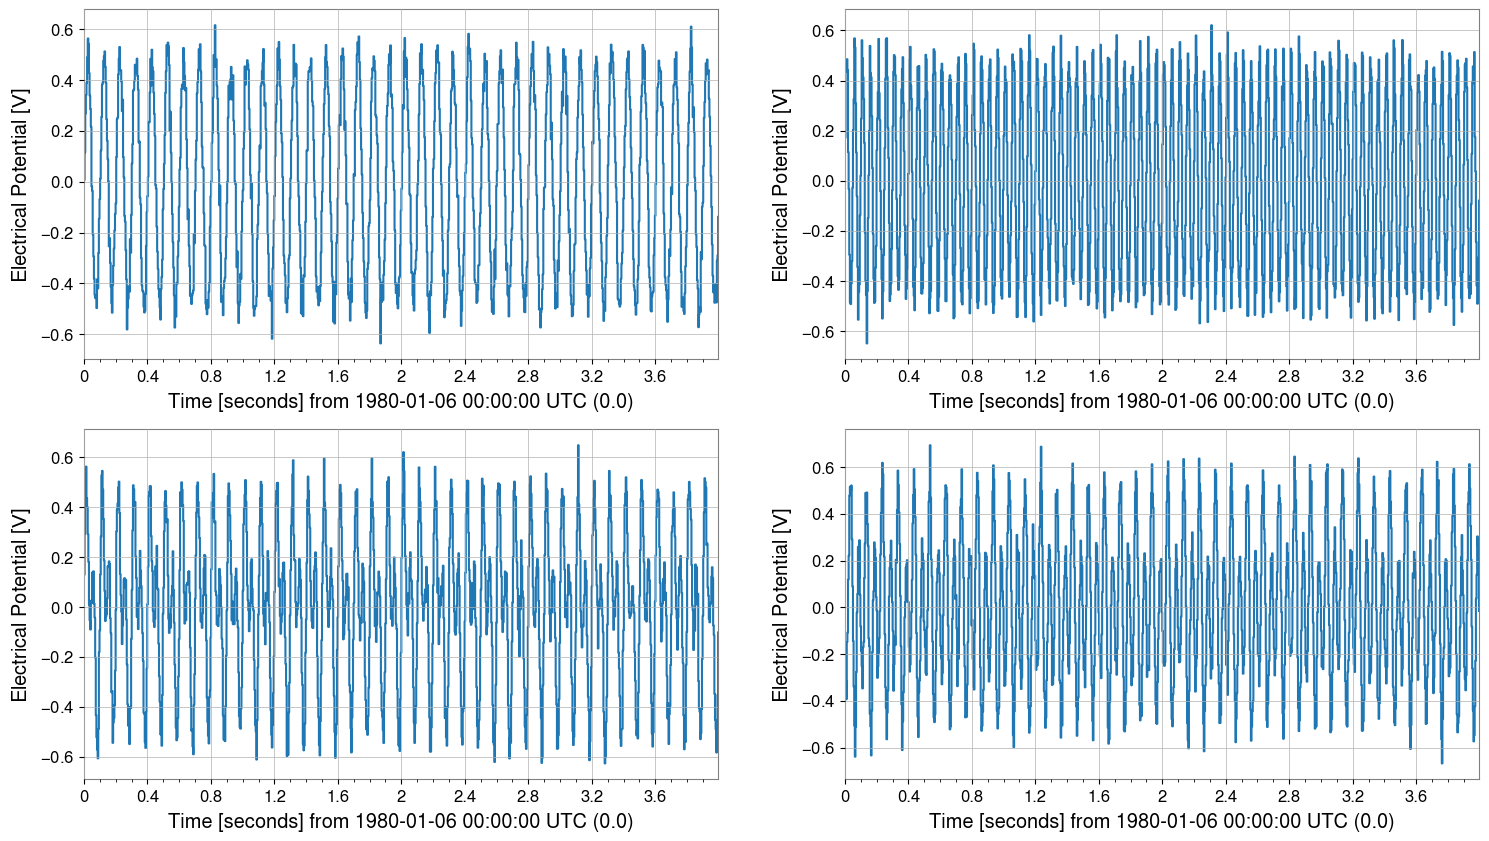

In [13]:
print("repr:\n", tsm)
display(tsm)

tsm.plot(subplots=True, xscale="seconds")
tsm.step(where="post", xscale="seconds");

## Summary
- `TimeSeriesMatrix` preserves TimeSeries-compatible axis information (`dt/t0/times`) and element metadata while enabling batch processing as a matrix.
- Time-domain processing (detrend/bandpass/resample, etc.) and spectral analysis (asd/psd/coherence, etc.) can be applied element-wise in batches.
- First extract a `TimeSeries` with `tsm[i, j]` to check behavior, then once familiar, process the entire matrix for convenience.